In [3]:
%load_ext autoreload
%autoreload 2

# Analyse ruggedness for different datasets

In [4]:
from sklearn.manifold import TSNE
import itertools
from functools import partial
import json
import jax.numpy as jnp
import numpy as np
import os
import pandas as pd
import jax
import seaborn as sns
import matplotlib.pyplot as plt
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict, write_json
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from evoscaper.utils.dataset import embellish_data
from evoscaper.utils.evolution import calculate_ruggedness_from_perturbations


jax.config.update('jax_platform_name', 'cpu')

jax.devices()

# jupyter nbconvert --to notebook --execute 14_ruggedness_add.ipynb --output=14_ruggedness_add_2.ipynb --ExecutePreprocessor.timeout=-1


[CpuDevice(id=0)]

In [5]:
def add_rugg(data: pd.DataFrame, interactions: np.ndarray, objective_cols: list, analytics: dict,
             resimulate_analytics: bool, eps: float, analytics_original=None):

    n_samples = interactions.shape[0]
    n_interactions = interactions.shape[1]
    n_perturbs = n_interactions + resimulate_analytics
    species = data['sample_name'].dropna().unique()
    n_species = len(species)

    for k in objective_cols:
        analytic_perturbed = jnp.array(
            analytics[k]).reshape(n_samples, n_perturbs, -1)
        if resimulate_analytics:
            analytic_perturbed = analytic_perturbed[:, :-1, :]
            analytic_og = analytic_perturbed[:, -1, :]
        else:
            analytic_og = np.array(analytics_original[k][:n_samples])

        # If loaded from previous data where not all analytics were saved
        if analytic_perturbed.shape[-1] != analytic_og.shape[-1]:
            analytic_perturbed = analytic_perturbed[..., -
                                                    analytic_og.shape[-1]:]

        analytic_perturbed = analytic_perturbed[..., -n_species:]
        analytic_og = analytic_og[..., -n_species:]

        ruggedness = jax.vmap(partial(calculate_ruggedness_from_perturbations, eps=eps))(
            analytic_perturbed, analytic_og[:, None, :])

        data[k + ' ruggedness'] = ruggedness.flatten()
    return data


def add_adaptation(d) -> dict | pd.DataFrame:
    if 'adaptation' not in d:
        d['adaptation'] = calculate_adaptation(
            np.array(d['sensitivity']), np.array(d['precision']), alpha=2)
    return d

# Biological resim: dataset 0211

## Add ruggedness to og dataset

In [3]:
fn_ds0211 = 'data/simulate_circuits/2025_02_11__13_56_51/tabulated_mutation_info.json'
dir_ds0211_rug1 = 'data/07_ruggedness/2025_03_05__15_19_07'
dir_ds0211_rug2 = 'data/07_ruggedness/2025_03_06__22_11_21'

data = pd.read_json(fn_ds0211)
analytics1 = load_json_as_dict(os.path.join(dir_ds0211_rug1, 'analytics.json'))
analytics2 = load_json_as_dict(os.path.join(dir_ds0211_rug2, 'analytics.json'))
config = load_json_as_dict(os.path.join(dir_ds0211_rug1, 'config.json'))
hpos = pd.Series(load_json_as_dict(os.path.join(os.path.dirname(config['fn_saves']), 'hpos_all.json')))
resimulate_analytics = config.get('resimulate_analytics', True)
objective_cols = ['adaptation', 'Log sensitivity', 'Log precision', 'overshoot', 'response_time']

In [4]:
analytics = {}
for k in analytics1:
    if k in analytics2:
        analytics[k] = np.concatenate([analytics1[k], analytics2[k]])
    else: print(k)

In [ ]:
analytics = add_adaptation(analytics)
data = add_adaptation(data)

In [10]:
filt = data['sample_name'] == data['sample_name'].dropna().unique()[-1]
interactions = data[filt][get_true_interaction_cols(
    data, hpos.loc['x_type'], remove_symmetrical=True)].values
n_samples = interactions.shape[0]
analytics_original = {'sensitivity': np.array(data['sensitivity']).reshape(n_samples, len(data['sample_name'].dropna().unique())),
                      'precision': np.array(data['precision']).reshape(n_samples, len(data['sample_name'].unique()))}
eps_perc = config.get('eps_perc', - 1e-2)
eps = eps_perc * np.abs(interactions).max()

data = add_rugg(data, interactions, objective_cols, analytics, resimulate_analytics, eps)


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='Log ruggedness (Log sensitivity)', ylabel='Count'>

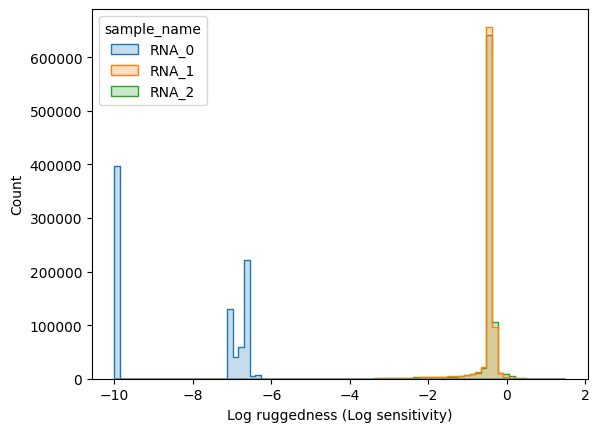

In [11]:
data['Log ruggedness (adaptation)'] = np.log10(data['adaptation ruggedness'])
data['Log ruggedness (Log sensitivity)'] = np.where(data['Log sensitivity ruggedness'] == 0, -10, np.log10(data['Log sensitivity ruggedness']))
sns.histplot(data, x='Log ruggedness (Log sensitivity)', hue='sample_name', bins=80, element='step')


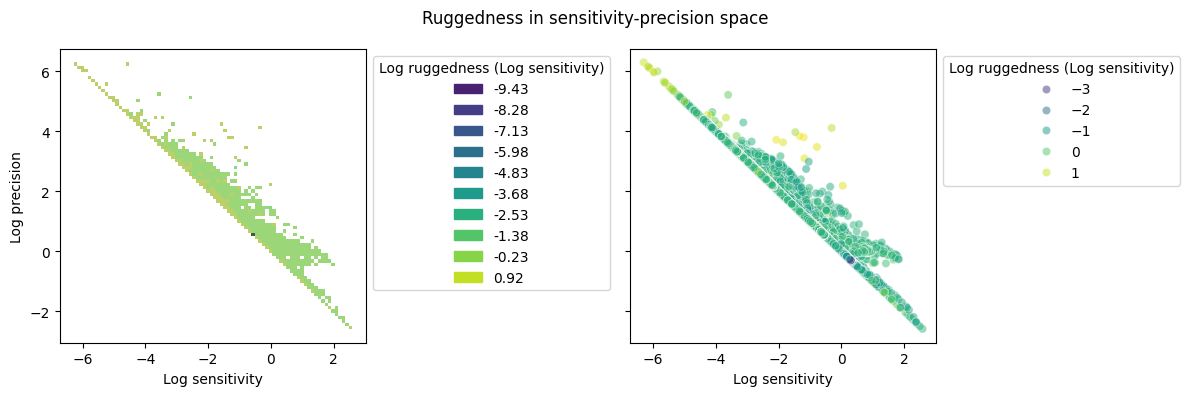

In [12]:
extra_cols = {}

extra_cols['Log sensitivity ruggedness bin'] = pd.cut(data['Log sensitivity ruggedness'], bins=10).apply(lambda x: np.round(x.mid, 2))
extra_cols['Log ruggedness (Log sensitivity) bin'] = pd.Series(pd.cut(data['Log ruggedness (Log sensitivity)'], bins=10)).apply(lambda x: np.round(x.mid, 2))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
g = sns.histplot(data, x='Log sensitivity', y='Log precision', hue=extra_cols['Log ruggedness (Log sensitivity) bin'], bins=80, palette='viridis', ax=axes[0])
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

g = sns.scatterplot(data[data['sample_name'] == 'RNA_2'], x='Log sensitivity', y='Log precision', hue='Log ruggedness (Log sensitivity)', palette='viridis', alpha=0.5, ax=axes[1])
# g = sns.scatterplot(data[(data['Log sensitivity'] > 0) & (data['Log precision'] > 0)], x='Log sensitivity', y='Log precision', hue='Log ruggedness (Log sensitivity)', palette='viridis', alpha=0.5)
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

plt.suptitle('Ruggedness in sensitivity-precision space')
plt.tight_layout()

In [13]:
write_json(data, fn_ds0211)

# Data 0129

In [6]:
fn_ds0129 = 'data/simulate_circuits/2025_01_29__18_12_38/tabulated_mutation_info.json'
dir_ds0129_rug = 'data/ruggedness/2025_04_29__23_21_26'

# data = pd.read_json(fn_ds0129)

In [7]:
analytics_0129 = {}
for batch_dir in sorted(os.listdir(dir_ds0129_rug)):
    if not batch_dir.startswith('batch'):
        continue
    a = load_json_as_dict(os.path.join(dir_ds0129_rug, batch_dir, 'analytics.json'))
    for k in a.keys():
        if k in analytics_0129:
            analytics_0129[k] = np.concatenate([analytics_0129[k], a[k]])
        else: 
            analytics_0129[k] = a[k]
analytics_0129 = embellish_data(analytics_0129)
analytics_0129 = add_adaptation(analytics_0129)
{k: len(v) for k, v in analytics_0129.items()}

/workdir/src/evoscaper/utils/dataset.py:109: RuntimeWarning: divide by zero encountered in log10
  data[k] != 0, np.log10(data[k]), zero_log_replacement)


{'RMSE': 7000000,
 'fold_change': 7000000,
 'initial_steady_states': 7000000,
 'max_amount': 7000000,
 'min_amount': 7000000,
 'overshoot': 7000000,
 'precision': 7000000,
 'response_time': 7000000,
 'sensitivity': 7000000,
 'steady_states': 7000000,
 'Log sensitivity': 7000000,
 'Log precision': 7000000,
 'adaptation': 7000000,
 'overshoot/initial': 7000000,
 'Log sensitivity > 0': 7000000,
 'Log precision > 1': 7000000}

In [ ]:
config = load_json_as_dict(os.path.join(dir_ds0129_rug, 'config.json'))
resimulate_analytics = config.get('resimulate_analytics', True)
objective_cols = ['adaptation', 'Log sensitivity', 'Log precision', 'overshoot', 'response_time']

filt = data['sample_name'] == data['sample_name'].dropna().unique()[-1]
interactions = data[filt][get_true_interaction_cols(
    data, hpos.loc['x_type'], remove_symmetrical=True)].values
n_samples = interactions.shape[0]
analytics_original = {'sensitivity': np.array(data['sensitivity']).reshape(n_samples, len(data['sample_name'].dropna().unique())),
                      'precision': np.array(data['precision']).reshape(n_samples, len(data['sample_name'].unique()))}
eps_perc = config.get('eps_perc', - 1e-2)
eps = eps_perc * np.abs(interactions).max()

data = add_adaptation(data)
data = add_rugg(data, interactions, objective_cols, analytics_0129, resimulate_analytics, eps)


data['Log ruggedness (adaptation)'] = np.log10(data['adaptation ruggedness'])
data['Log ruggedness (Log sensitivity)'] = np.where(data['Log sensitivity ruggedness'] == 0, -10, np.log10(data['Log sensitivity ruggedness']))
sns.histplot(data, x='Log ruggedness (Log sensitivity)', hue='sample_name', bins=80, element='step')

In [ ]:
extra_cols = {}

extra_cols['Log sensitivity ruggedness bin'] = pd.cut(data['Log sensitivity ruggedness'], bins=10).apply(lambda x: np.round(x.mid, 2))
extra_cols['Log ruggedness (Log sensitivity) bin'] = pd.Series(pd.cut(data['Log ruggedness (Log sensitivity)'], bins=10)).apply(lambda x: np.round(x.mid, 2))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
g = sns.histplot(data, x='Log sensitivity', y='Log precision', hue=extra_cols['Log ruggedness (Log sensitivity) bin'], bins=80, palette='viridis', ax=axes[0])
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

g = sns.scatterplot(data[data['sample_name'] == 'RNA_2'], x='Log sensitivity', y='Log precision', hue='Log ruggedness (Log sensitivity)', palette='viridis', alpha=0.5, ax=axes[1])
# g = sns.scatterplot(data[(data['Log sensitivity'] > 0) & (data['Log precision'] > 0)], x='Log sensitivity', y='Log precision', hue='Log ruggedness (Log sensitivity)', palette='viridis', alpha=0.5)
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

plt.suptitle('Ruggedness in sensitivity-precision space')
plt.tight_layout()

# Data 1127

In [ ]:
fn_ds1127 = '../data/raw/summarise_simulation/2024_11_27_145142/tabulated_mutation_info.csv'
dir_ds1127_rug = 'data/07_ruggedness/2025_03_14__14_46_55'

data_1127 = pd.read_csv(fn_ds1127)
config_1127 = load_json_as_dict(os.path.join(dir_ds1127_rug, 'config.json'))
hpos_1127 = pd.Series(load_json_as_dict(os.path.join(os.path.dirname(config_1127['fn_saves']), 'hpos_all.json')))
resimulate_analytics_1127 = config_1127.get('resimulate_analytics', True)

In [ ]:

# (
#     rng, rng_model, rng_dataset,
#     config_norm_x, config_norm_y, config_filter, config_optimisation, config_dataset, config_training, config_model,
#     data, x_cols, df,
#     x, cond, y, x_train, cond_train, y_train, x_val, cond_val, y_val,
#     total_ds, n_batches, BATCH_SIZE, x_datanormaliser, x_methods_preprocessing, y_datanormaliser, y_methods_preprocessing,
#     params, encoder, decoder, model, h2mu, h2logvar, reparam
# ) = init_from_hpos(hpos)


In [ ]:
analytics_1127 = {}
for batch_dir in sorted(os.listdir(dir_ds1127_rug)):
    if not batch_dir.startswith('batch'):
        continue
    a = load_json_as_dict(os.path.join(dir_ds1127_rug, batch_dir, 'analytics.json'))
    for k in a.keys():
        if k in analytics_1127:
            analytics_1127[k] = np.concatenate([analytics_1127[k], a[k]])
        else: 
            analytics_1127[k] = a[k]
analytics_1127 = embellish_data(analytics_1127)
{k: len(v) for k, v in analytics_1127.items()}

In [ ]:
filt = data_1127['sample_name'] == data_1127['sample_name'].dropna(
).unique()[-1]
interactions_1127 = data_1127[filt][get_true_interaction_cols(
    data_1127, hpos_1127.loc['x_type'], remove_symmetrical=True)].values
n_samples = interactions_1127.shape[0]
analytics_original_1127 = {'sensitivity': np.array(data_1127['sensitivity']).reshape(n_samples, len(data_1127['sample_name'].dropna().unique())),
                           'precision': np.array(data_1127['precision']).reshape(n_samples, len(data_1127['sample_name'].unique()))}
eps_perc = config_1127.get('eps_perc', - 1e-2)
eps = eps_perc * np.abs(interactions_1127).max()


In [ ]:
len(data_1127) / 3, len(analytics_1127['sensitivity'])

(845000.0, 576037)

In [ ]:
objective_cols = ['Log sensitivity', 'Log precision', 'overshoot', 'response_time']

data_1127 = add_rugg(data_1127, interactions_1127, objective_cols,
                     analytics_1127, resimulate_analytics, eps, analytics_original=analytics_original_1127)

TypeError: cannot reshape array of shape (576037, 9) (size 5184333) into shape (845000, 7, -1) because the product of specified axis sizes (5915000) does not evenly divide 5184333

In [ ]:
data_1127['Log ruggedness (Log sensitivity)'] = np.where(data_1127['Log sensitivity ruggedness'] == 0, -10, np.log10(data_1127['Log sensitivity ruggedness']))
sns.histplot(data_1127, x='Log ruggedness (Log sensitivity)', hue='sample_name', bins=80, element='step')


NameError: name 'data_1127' is not defined

In [ ]:
write_json(data_1127, fn_ds1127)


NameError: name 'data_1127' is not defined